# Pix2Pix - Image to image translation with Conditional Adversarial Networks
> A tutorial on Pix2Pix Conditional GANs and implementation with PyTorch

- toc: false 
- badges: true
- comments: true
- categories: [gans, pytorch]
- image: https://ik.imagekit.io/aniket/blog/pix2pix/overview_eTCam8Vc0?tr=w-1200,h-628,fo-auto

## Author Introduction
> Hi! My name is Aniket Maurya. I am a Machine Learning Engineer at Quinbay Technologies, India. I research and build ML products for an e-commerce giant. I like to share my limited knowledge of Machine Learning and Deep Learning with on my blog or YouTube channel. You can connect with me on [Linkedin](https://linkedin.com/in/aniketmaurya)/[Twitter](https://twitter.com/aniketmaurya).

## Introduction to Conditional Adversarial Networks

![Pix2Pix example 01](https://ik.imagekit.io/aniket/blog/pix2pix/pix2pix-training_4eZEIv0Mo)

Image to Image translation means transforming the given source image into a different image. Gray scale image to colour image conversion is one such example of image of image translation. 

In this tutorial we will discuss GANs, a few points from Pix2Pix paper and implement the Pix2Pix network to translate segmented facade into real pictures.
We will create the Pix2Pix model in PyTorch and use PyTorch lightning to avoid boilerplates.

GANs are Generative models that learns a mapping from random noise vector to an output image.
`G(z) -> Image (y)`

For example, GANs can learn mapping from random normal vectors to generate smiley images. For training such a GAN we just need a set of smiley images and train the GAN with an adversarial loss 🙂. After the model is trained we can use random normal noise vectors to generate images that were not in the training dataset.

But what if we want to build a network in such a way that we can control what the model will generate. In our case we want the model to generate a laughing smiley.

Conditional GANs are Generative networks which learn mapping from random noise vectors and a conditional vector to output an image.
Suppose we have 4 types of smileys - smile, laugh, sad and angry (🙂 😂 😔 😡). So our class vector for smile 🙂 can be `(1,0,0,0)`, laugh can be 😂 `(0,1,0,0)` and similarly for others.
Here the conditional vector is the smiley embedding.

During training of the generator the conditional image is passed to the generator and fake image is generated. The fake image is then passed through the discriminator along with the conditional image, both fake image and conditional image are concatenated. Discriminator penalizes the generator if it correctly classifies the fake image as fake.



## Pix2Pix

**Pix2Pix** is an image-to-image translation Generative Adversarial Networks that learns a mapping from an image X and a random noise Z to output image Y or in simple language it learns to translate the source image into a different image.

During the time Pix2Pix was released, several other works were also using Conditional GANs on discrete labels. Pix2Pix uses a U-Net based architecture for the Generator and for the Discriminator a `PathGAN Classifier` is used.

![Pix2Pix Generator arch](https://ik.imagekit.io/aniket/blog/pix2pix/pix2pix_Unet_arch_Oen99KmZw)

Pix2Pix Generator is an U-Net based architecture which is an encoder-decoder network with skip connections. Both generator and discriminator uses **Convolution-BatchNorm-ReLu** like module or in simple words we can say that it is the unit block of the generator and discriminator.
Skip connections are added between each layer i and layer `n−i`, where n is the total number of layers. At each skip connection all the channels from current layer i are concatenated with all the channels at `n-i` layer.

Lets understand more with code

In [3]:
# hide
!pip install -q pytorch-lightning

In [4]:
# collapse-hide
import os
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.transforms.functional import center_crop
from torchvision.utils import make_grid
from tqdm.auto import tqdm

Uncomment the below code to download the dataset

In [ ]:
# !wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
# !tar -xvf facades.tar.gz

After downloading the dataset we create Dataloader which loads our conditional and real image.

In [6]:
path = "./facades/train/"


class FacadesDataset(Dataset):
    def __init__(self, path, target_size=None):
        self.filenames = glob(str(Path(path) / "*"))
        self.target_size = target_size

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        image = Image.open(filename)
        image = transforms.functional.to_tensor(image)
        image_width = image.shape[2]

        real = image[:, :, : image_width // 2]
        condition = image[:, :, image_width // 2 :]

        target_size = self.target_size
        if target_size:
            condition = nn.functional.interpolate(condition, size=target_size)
            real = nn.functional.interpolate(real, size=target_size)

        return real, condition

We create the unit module that will be used in Generator and Discriminator (**Convolution->BatchNorm->ReLu**). We also keep our option open to use **DropOut** layer when we need.

In [7]:
class ConvBlock(nn.Module):
    """
    Unit block of the Pix2Pix
    """

    def __init__(self, in_channels, out_channels, use_dropout=False, use_bn=True):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

        if use_bn:
            self.batchnorm = nn.BatchNorm2d(out_channels)
        self.use_bn = use_bn

        if use_dropout:
            self.dropout = nn.Dropout()
        self.use_dropout = use_dropout
        self.activation = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.conv1(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        return x

In the first part of U-Net network the layer size decreases, we create a `DownSampleConv` module for this. This module will contain the unit block that we just created `ConvBlock`.

In [8]:
class DownSampleConv(nn.Module):
    def __init__(self, in_channels, use_dropout=False, use_bn=False):
        super().__init__()

        self.conv_block1 = ConvBlock(in_channels, in_channels * 2, use_dropout, use_bn)
        self.conv_block2 = ConvBlock(
            in_channels * 2, in_channels * 2, use_dropout, use_bn
        )
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.maxpool(x)
        return x

Now in the second part the network expands and so we create `UpSampleConv`

In [9]:
class UpSampleConv(nn.Module):
    def __init__(self, input_channels, use_dropout=False, use_bn=True):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv1 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=2)
        self.conv2 = nn.Conv2d(
            input_channels, input_channels // 2, kernel_size=3, padding=1
        )
        self.conv3 = nn.Conv2d(
            input_channels // 2, input_channels // 2, kernel_size=2, padding=1
        )
        if use_bn:
            self.batchnorm = nn.BatchNorm2d(input_channels // 2)
        self.use_bn = use_bn
        self.activation = nn.ReLU()
        if use_dropout:
            self.dropout = nn.Dropout()
        self.use_dropout = use_dropout

    def forward(self, x, skip_con_x):

        x = self.upsample(x)
        x = self.conv1(x)
        skip_con_x = center_crop(skip_con_x, x.shape[-2:])
        x = torch.cat([x, skip_con_x], axis=1)
        x = self.conv2(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.conv3(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        return x

Now the basic blocks of the Pix2Pix generated is created, we create the generator module. Generator is formed of expanding and contracting layers.
The first part network contracts and then expands again, i.e. first we have encoder block and then decoder block.
Below is the encoder-decoder of U-Net network configuration from official paper. Here `C` denotes the unit block that we created `ConvBlock` and `D` denotes `Drop Out` with value _0.5_.
In the decoder, the output tensors from `n-i` layer of encoder concatenates with `i` layer of the decoder. Also the first three blocks of the decoder has drop out layers.

```
Encoder:  C64-C128-C256-C512-C512-C512-C512-C512

Decoder:  CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128
```

In [10]:
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=32, depth=6):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, hidden_channels, kernel_size=1)

        self.conv_final = nn.Conv2d(hidden_channels, out_channels, kernel_size=1)
        self.depth = depth

        self.contracting_layers = []
        self.expanding_layers = []
        self.final_act = nn.Tanh()

        # encoding/contracting path of the Generator
        for i in range(depth):
            down_sample_conv = DownSampleConv(
                hidden_channels * 2 ** i,
            )
            self.contracting_layers.append(down_sample_conv)

        # decoder/Expanding path of the Generator
        for i in range(depth):
            upsample_conv = UpSampleConv(
                hidden_channels * 2 ** (i + 1), use_dropout=(True if i < 3 else False)
            )
            self.expanding_layers.append(upsample_conv)

        self.contracting_layers = nn.ModuleList(self.contracting_layers)
        self.expanding_layers = nn.ModuleList(self.expanding_layers)

    def forward(self, x):
        depth = self.depth
        contractive_x = []

        x = self.conv1(x)
        contractive_x.append(x)

        for i in range(depth):
            x = self.contracting_layers[i](x)
            contractive_x.append(x)

        for i in range(depth - 1, -1, -1):
            x = self.expanding_layers[i](x, contractive_x[i])
        x = self.conv_final(x)

        return self.final_act(x)

### Discriminator
A discriminator is a ConvNet which learns to classify images into discrete labels. In GANs, discriminators learns to predict whether the given image is real or fake.
PatchGAN is the discriminator used for Pix2Pix. Its architecture is different from a typical image classification ConvNet because of the output layer size. In convnets output layer size is equal to the number of classes while in PatchGAN output layer size is a 2D matrix.

Now we create our Discriminator - **PatchGAN**. In this network we use the same `DownSampleConv` module that we created for generator.

In [11]:
class PatchGAN(nn.Module):

    def __init__(self, input_channels, hidden_channels=8):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, hidden_channels, kernel_size=1)
        self.contract1 = DownSampleConv(hidden_channels, use_bn=False)
        self.contract2 = DownSampleConv(hidden_channels * 2)
        self.contract3 = DownSampleConv(hidden_channels * 4)
        self.contract4 = DownSampleConv(hidden_channels * 8)
        self.final = nn.Conv2d(hidden_channels * 16, 1, kernel_size=1)

    def forward(self, x, y):
        x = torch.cat([x, y], axis=1)
        x0 = self.conv1(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        xn = self.final(x4)
        return xn

### Loss Function

Loss function used in Pix2Pix are `Adversarial loss` and  `Reconstruction loss`. Adversarial loss is used to penalize the generator to predict more realistic images. In conditional GANs, generators job is not only to produce realistic image but also to be near the ground truth output. Reconstruction Loss helps network to produce the realistic image near the conditional image.

```python
adversarial_loss = nn.BCEWithLogitsLoss()

reconstruction_loss = nn.L1Loss()
```

In [12]:
#collapse-hide
# https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch

def _weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [13]:
class Pix2Pix(pl.LightningModule):
    def __init__(self,
                 in_channels,
                 out_channels,
                 hidden_channels=32,
                 depth=6,
                 learning_rate=0.0002,
                 lambda_recon=200):

        super().__init__()
        self.save_hyperparameters()

        self.gen = Generator(in_channels, out_channels, hidden_channels, depth)
        self.patch_gan = PatchGAN(in_channels + out_channels, hidden_channels=8)

        # intializing weights
        self.gen = self.gen.apply(_weights_init)
        self.patch_gan = self.patch_gan.apply(_weights_init)

        self.adversarial_criterion = nn.BCEWithLogitsLoss()
        self.recon_criterion = nn.L1Loss()

    def _gen_step(self, real_images, conditioned_images):
        # Pix2Pix has adversarial and a reconstruction loss
        # First calculate the adversarial loss
        fake_images = self.gen(conditioned_images)
        disc_logits = self.patch_gan(fake_images, conditioned_images)
        adversarial_loss = self.adversarial_criterion(disc_logits, torch.ones_like(disc_logits))

        # calculate reconstruction loss
        recon_loss = self.recon_criterion(fake_images, real_images)
        lambda_recon = self.hparams.lambda_recon

        return adversarial_loss + lambda_recon * recon_loss

    def _disc_step(self, real_images, conditioned_images):
        fake_images = self.gen(conditioned_images).detach()
        fake_logits = self.patch_gan(fake_images, conditioned_images)

        real_logits = self.patch_gan(real_images, conditioned_images)

        fake_loss = self.adversarial_criterion(fake_logits, torch.zeros_like(fake_logits))
        real_loss = self.adversarial_criterion(real_logits, torch.ones_like(real_logits))
        return (real_loss + fake_loss) / 2

    def configure_optimizers(self):
        lr = self.hparams.learning_rate
        gen_opt = torch.optim.Adam(self.gen.parameters(), lr=lr)
        disc_opt = torch.optim.Adam(self.patch_gan.parameters(), lr=lr)
        return disc_opt, gen_opt

    def training_step(self, batch, batch_idx, optimizer_idx):
        real, condition = batch

        loss = None
        if optimizer_idx == 0:
            loss = self._disc_step(real, condition)
            self.log('PatchGAN Loss', loss)
        elif optimizer_idx == 1:
            loss = self._gen_step(real, condition)
            self.log('Generator Loss', loss)
        
        if self.current_epoch%10==0 and batch_idx==0 and optimizer_idx==1:
            fake = self.gen(condition).detach()
            show_tensor_images(condition[0])
            show_tensor_images(real[0])
            show_tensor_images(fake[0])
        return loss

Now that the network is implemented now we are ready to train. You can also modify the dataloader and train on custom dataset.

Hope you liked the article! Happy training 😃

In [17]:
# hide
# These configurations are from paper

adv_criterion = nn.BCEWithLogitsLoss() 
recon_criterion = nn.L1Loss() 
lambda_recon = 200

n_epochs = 20

display_step = 200
batch_size = 4
lr = 0.0002
target_size = 256
device = 'cuda'

def show_tensor_images(image_tensor,
                       num_images=25,
                       size=(3, 64, 64),
                       ret=False):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    if ret:
        return image_grid.permute(1, 2, 0).squeeze()
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type              | Params
------------------------------------------------------------
0 | gen                   | Generator         | 117 M 
1 | patch_gan             | PatchGAN          | 294 K 
2 | adversarial_criterion | BCEWithLogitsLoss | 0     
3 | recon_criterion       | L1Loss            | 0     
------------------------------------------------------------
117 M     Trainable params
0         Non-trainable params
117 M     Total params


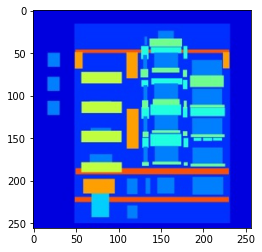

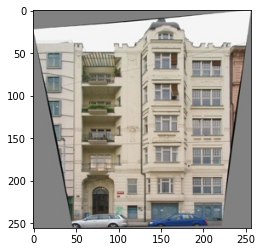

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


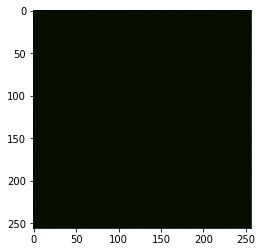

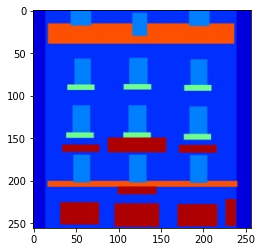

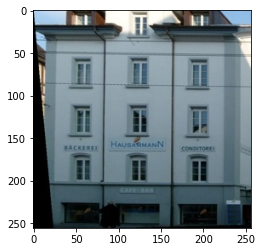

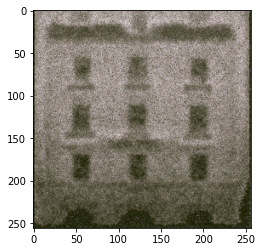

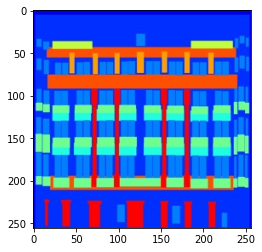

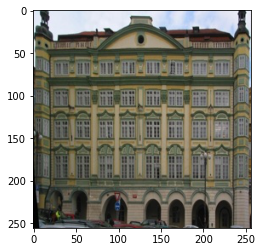

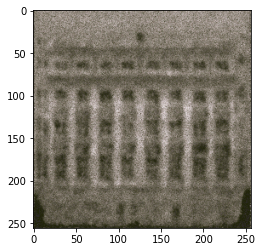

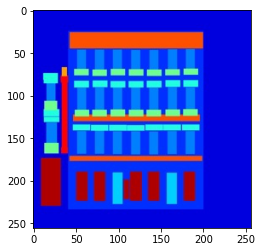

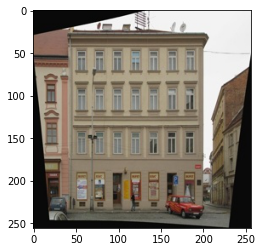

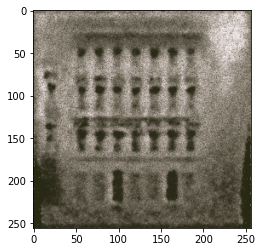

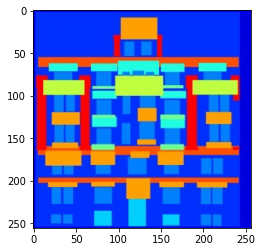

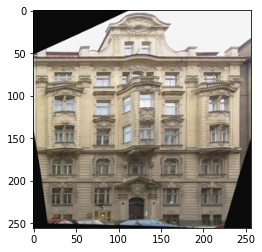

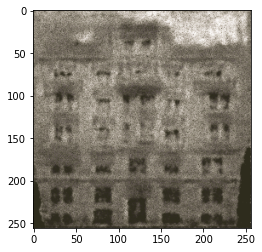

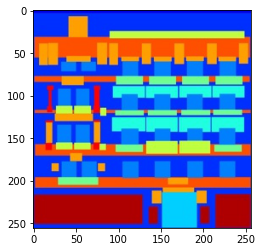

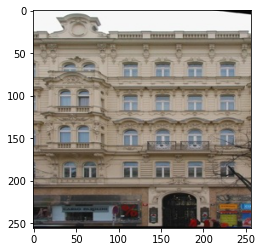

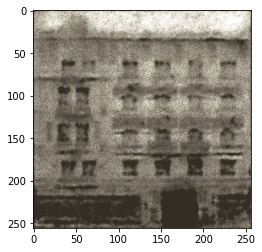

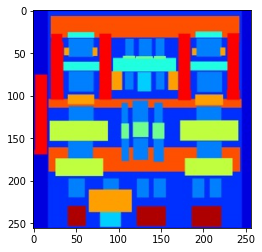

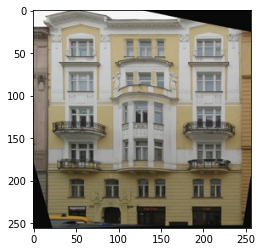

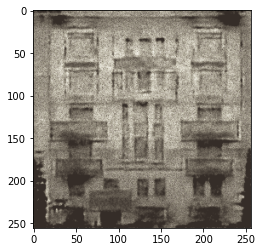

In [ ]:
dataset = FacadesDataset(path, target_size=target_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

pix2pix = Pix2Pix(3, 3)
trainer = pl.Trainer(max_epochs=100, gpus=1)
trainer.fit(pix2pix, dataloader)